In [1]:
%config InlineBackend.figure_format = 'svg'
from datetime import datetime
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from skylark import skylark_root, MB, GB
from skylark.gateway.chunk import ChunkState

base_dir = skylark_root / "data" / "experiments" / "benchmark_triangles"
fig_dir = base_dir / "figures" / "benchmark_triangles" / datetime.now().strftime("%Y%m%d_%H%M%S")
fig_dir.mkdir(exist_ok=True, parents=True)

In [2]:
configs = list((base_dir / "logs").glob("*"))

rows = []
for config in configs:
    for f in (skylark_root / "data" / "experiments" / "benchmark_triangles" / config / "results").glob("*.pkl"):
        with open(f, "rb") as fp:
            result = pickle.load(fp)
        rows.append(result)
df = pd.DataFrame(rows)
df_orig = df.copy()

if "error" in df.columns:
    for row in df[df.error.notnull()].itertuples():
        print(f"{row.src_region} -> {row.dst_region} -> {row.inter_region}: {row.error}")
    df = df[df.error.isnull()]
df

aws:eu-central-1 -> aws:us-east-1 -> aws:af-south-1: create_keyfile() takes 0 positional arguments but 2 were given
aws:us-east-1 -> aws:us-west-1 -> aws:af-south-1: create_keyfile() takes 0 positional arguments but 2 were given
aws:ap-southeast-1 -> aws:eu-west-1 -> aws:af-south-1: create_keyfile() takes 0 positional arguments but 2 were given


,completed_chunk_ids,total_runtime_s,throughput_gbits,monitor_status,success,log,src_region,dst_region,inter_region,num_gateways,num_outgoing_connections,chunk_size_mb,n_chunks,error
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",59.173366,2.163135,completed,True,chunk_id sta...,aws:eu-central-1,aws:us-east-1,aws:ap-southeast-2,1,64,8,2048,NaN
1,[],5.908054,0.000000,timed_out,True,chunk_id stat...,aws:eu-central-1,aws:us-east-1,aws:eu-west-2,1,64,8,2048,NaN
2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",34.427262,3.717984,completed,True,chunk_id sta...,aws:eu-central-1,aws:us-east-1,aws:us-east-2,1,64,8,2048,NaN
3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",51.780761,2.471961,completed,True,chunk_id sta...,aws:eu-central-1,aws:us-east-1,aws:ap-northeast-2,1,64,8,2048,NaN
4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",38.064445,3.362718,completed,True,chunk_id sta...,aws:eu-central-1,aws:us-east-1,None,1,64,8,2048,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",37.762711,3.389587,completed,True,chunk_id sta...,aws:sa-east-1,aws:us-west-2,aws:us-east-1,1,64,8,2048,NaN
69,"[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 13, 15, 16...",35.529976,0.042218,timed_out,True,chunk_id sta...,aws:sa-east-1,aws:us-west-2,aws:us-east-2,1,64,8,2048,NaN
70,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",45.425690,2.817789,completed,True,chunk_id sta...,aws:sa-east-1,aws:us-west-2,aws:eu-west-3,1,64,8,2048,NaN
71,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",73.433558,1.743072,completed,True,chunk_id sta...,aws:sa-east-1,aws:us-west-2,aws:ap-southeast-1,1,64,8,2048,NaN


In [3]:
if False:
    for (src, dst), group_df in df.groupby(["src_region", "dst_region"]):
        group_df = group_df.reset_index(drop=True)
        group_df = group_df[(group_df.inter_region != src) & (group_df.inter_region != dst)]

        # sort by throughput_gbits
        group_df = group_df.sort_values(by="throughput_gbits", ascending=True)
        group_df["inter_region"] = group_df.inter_region.fillna("Direct")
        group_df["label"] = group_df.apply(lambda row: f"{row.inter_region} ({row.num_gateways} x {row.num_outgoing_connections})", axis=1)
        group_df["transfer_bytes"] = group_df.apply(lambda row: row.n_chunks * row.chunk_size_mb * MB, axis=1)
        assert np.all(group_df.transfer_bytes == group_df.transfer_bytes[0])

        # plot barh
        # title = f"Skylark throughput {src} => {dst}, {group_df.transfer_bytes[0] / GB:.2f}GB in group_df.num_chunks[0]x group_df.chunk_size_mb[0]MB chunks"
        with plt.style.context(["seaborn-white", {"font.size": 10}]):
            fig, ax = plt.subplots(figsize=(8, 6))
            ax.barh(
                group_df.label,
                group_df.throughput_gbits,
            )
            ax.set_xlabel("Throughput (Gbps)")
            ax.set_ylabel("Inter-region relay")
            ax.set_title(f"{src} => {dst}, {group_df.transfer_bytes[0] / GB:.2f}GB ({group_df.n_chunks[0]}x{group_df.chunk_size_mb[0]}MB)")

            # add white labels to each bar
            for i, (label, throughput) in enumerate(zip(group_df.label, group_df.throughput_gbits)):
                # assert i, throughput not NaN
                if not np.isnan(throughput):
                    ax.text(
                        throughput,
                        i,
                        f"{throughput:.2f} Gbps ",
                        ha="right",
                        va="center",
                        color="white",
                    )
            
            # save plots
            fig.tight_layout()
            fig.savefig(fig_dir / f"{src}_{dst}.png", dpi=300, bbox_inches="tight")
            fig.savefig(fig_dir / f"{src}_{dst}.pdf", dpi=300, bbox_inches="tight")

In [4]:
# vectorized version
def compute_throughput_df(df_log, chunk_size_bytes):
    df_log = df_log.reset_index(drop=True).set_index(['path_idx', 'hop_idx', 'chunk_id', 'state']).sort_index()
    unstacked_time = df_log.time.unstack(level=3)
    unstacked_time.columns = [f"{col.name}_time" for col in unstacked_time.columns]
    unstacked_time['runtime_upload'] = (unstacked_time['upload_complete_time'] - unstacked_time['upload_in_progress_time']).dt.total_seconds()
    unstacked_time['runtime_download'] = (unstacked_time['downloaded_time'] - unstacked_time['download_in_progress_time']).dt.total_seconds()
    unstacked_time['runtime_queue'] = (unstacked_time['upload_in_progress_time'] - unstacked_time['upload_queued_time']).dt.total_seconds()
    unstacked_time['runtime_total'] = (unstacked_time['upload_complete_time'] - unstacked_time['registered_time']).dt.total_seconds()
    unstacked_time['upload_gbits'] = (chunk_size_bytes / GB * 8) / unstacked_time['runtime_upload']
    unstacked_time['download_gbits'] = (chunk_size_bytes / GB * 8) / unstacked_time['runtime_download']
    return unstacked_time
    

In [14]:
# plot grid of subplots
grouped = df.groupby(["src_region", "dst_region"])
n_rows = len(grouped.groups)
n_cols = max(len(grouped.get_group(group).inter_region.unique()) for group in grouped.groups)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
with tqdm(total=n_rows * n_cols) as pbar:
    for plot_row_idx, ((src_region, dst_region), df_row) in enumerate(grouped):
        # set subplots row labels on left of plot
        df_row['inter_region'] = df_row.inter_region.fillna("Direct")
        axs[plot_row_idx, 0].set_ylabel(f"{src_region} => {dst_region}")
        for plot_col_idx, (inter_region, df_plot) in enumerate(df_row.groupby("inter_region")):
            if plot_row_idx == 0:
                axs[plot_row_idx, plot_col_idx].set_title(f"Relay: {inter_region}")
            ax = axs[plot_row_idx, plot_col_idx]
            row = df_plot.iloc[0]
            runtime_df = compute_throughput_df(row['log'], row['chunk_size_mb'] * MB)
            # remove rows where runtime_upload or runtime_download is less than 0.1s
            with plt.style.context(["seaborn-white", {"font.size": 10}]):
                # plot histogram of runtime_upload, runtime_download
                # plot upload if mean upload time is greater than 0.1s
                runtime_upload_filtered = runtime_df[runtime_df.runtime_upload > 0.1]
                ax.hist(runtime_upload_filtered.runtime_upload, bins=50, label="upload", alpha=0.5)
                # plot download if mean download time is greater than 0.1s
                runtime_download_filtered = runtime_df[runtime_df.runtime_download > 0.2]
                ax.hist(runtime_df.runtime_download, bins=50, label="download", alpha=0.5)
                ax.legend()
                ax.set_xlabel("runtime (s)")
                ax.set_xlim(0, 5.)
            pbar.update(1)

fig.patch.set_facecolor('white')
fig.tight_layout()
fig.savefig(fig_dir / "runtime_hist.png", dpi=100, bbox_inches="tight")
fig.savefig(fig_dir / "runtime_hist.pdf", bbox_inches="tight")


  0%|          | 0/65 [00:00<?, ?it/s]

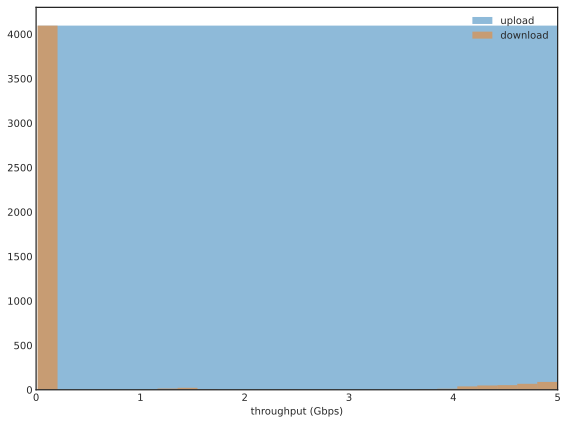

In [10]:
# show upload_gbits and download_gbits distribution over all chunks over all hops
df_throughput = compute_throughput_df(df.log.iloc[0], df.chunk_size_mb.iloc[0] * MB)
with plt.style.context(["seaborn-white", {"font.size": 10}]):
    # discard rows where runtime_upload or runtime_download is less than 0.1s
    runtime_df = df_throughput.loc[(df_throughput.runtime_upload > 0.1) & (df_throughput.runtime_download > 0.1)]
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.hist(df_throughput.upload_gbits, bins=50, alpha=0.5, label="upload")
    ax.hist(df_throughput.download_gbits, bins=50, alpha=0.5, label="download")
    ax.legend()
    ax.set_xlabel("throughput (Gbps)")
    ax.set_xlim(0, 5.)

fig.patch.set_facecolor('white')
fig.tight_layout()
fig.savefig(fig_dir / "throughput_hist.png", dpi=100, bbox_inches="tight")
fig.savefig(fig_dir / "throughput_hist.pdf", bbox_inches="tight")

  0%|          | 0/65 [00:00<?, ?it/s]

ValueError: max() arg is an empty sequence

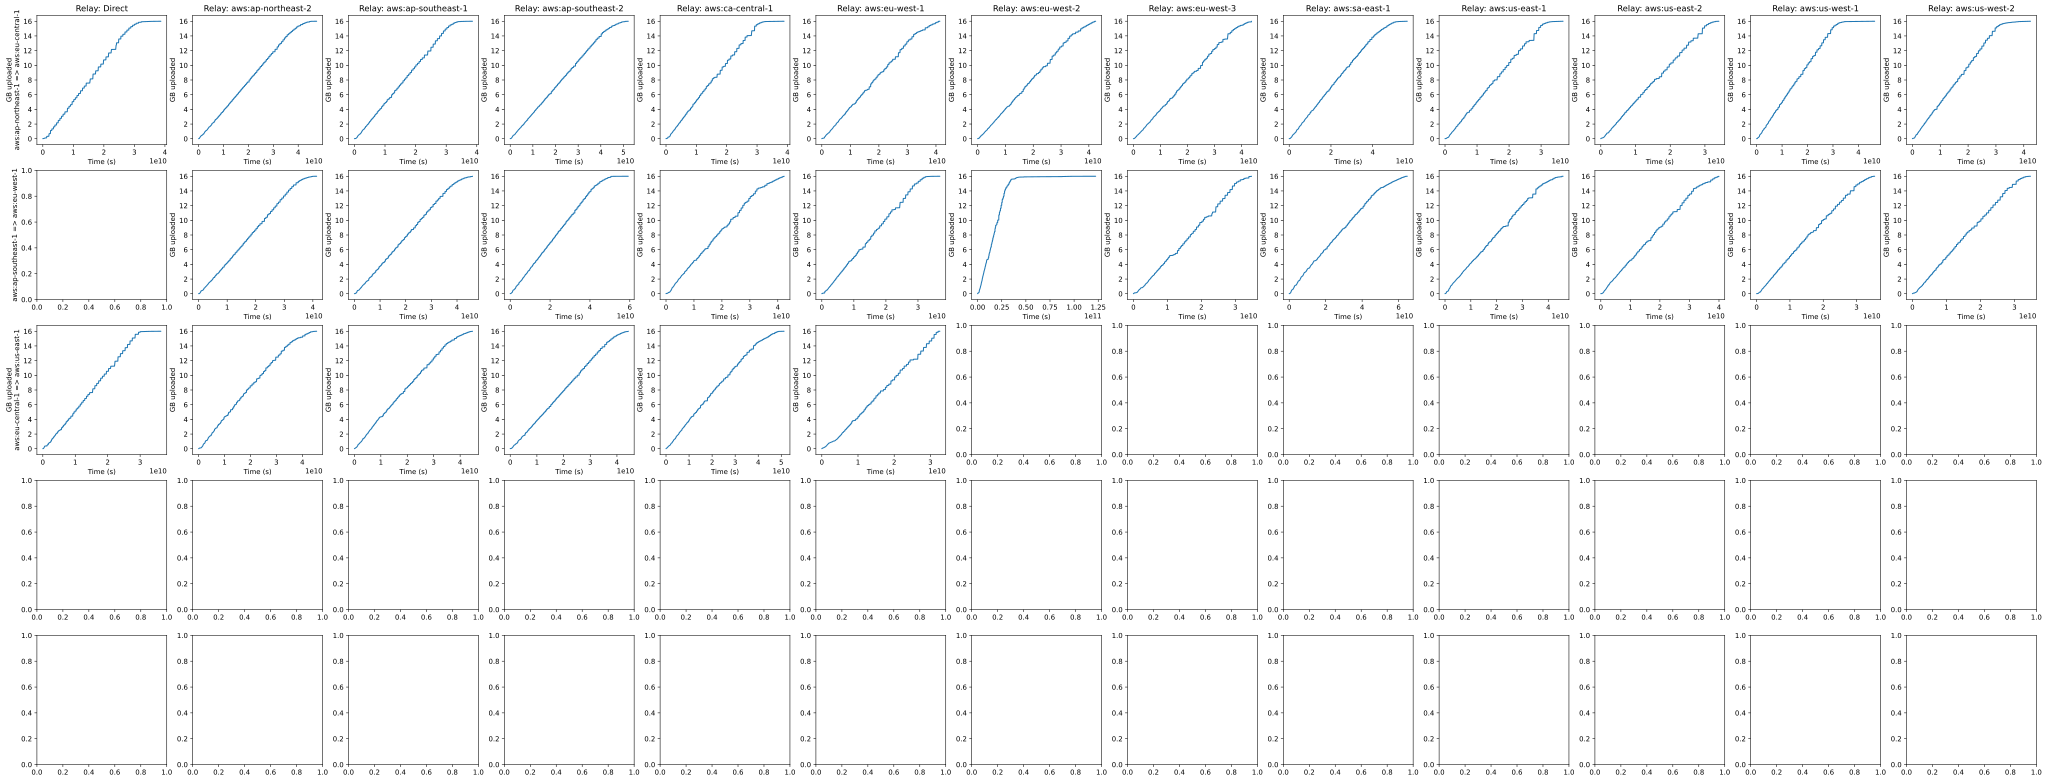

In [42]:
sub_dir = fig_dir / "bytes_complete_over_time"
sub_dir.mkdir(parents=True, exist_ok=True)

# plot grid of subplots
grouped = df.groupby(["src_region", "dst_region"])
n_rows = len(grouped.groups)
n_cols = max(len(grouped.get_group(group).inter_region.unique()) for group in grouped.groups)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
with tqdm(total=n_rows * n_cols) as pbar:
    for plot_row_idx, ((src_region, dst_region), df_row) in enumerate(grouped):
        # set subplots row labels on left of plot
        df_row['inter_region'] = df_row.inter_region.fillna("Direct")
        transfer_bytes = df_row.chunk_size_mb.values[0] * MB
        axs[plot_row_idx, 0].set_ylabel(f"{src_region} => {dst_region}")
        for plot_col_idx, (inter_region, df_plot) in enumerate(df_row.groupby("inter_region")):
            if plot_row_idx == 0:
                axs[plot_row_idx, plot_col_idx].set_title(f"Relay: {inter_region}")
            ax = axs[plot_row_idx, plot_col_idx]
            row = df_plot.iloc[0]
            runtime_df = compute_throughput_df(row['log'], row['chunk_size_mb'] * MB).reset_index()
            runtime_df = runtime_df[runtime_df['hop_idx'] == max(runtime_df['hop_idx'])]

            # select ['upload_complete_time'] column
            time_uploaded_df = runtime_df.loc[:, ['upload_complete_time']].dropna().reset_index(drop=True).sort_values(by='upload_complete_time').reset_index(drop=True)
            # bytes_uploaded = (idx + 1) * transfer_bytes
            time_uploaded_df['bytes_uploaded'] = (time_uploaded_df.index + 1) * transfer_bytes
            if len(time_uploaded_df) > 0:
                time_uploaded_df['upload_complete_time'] = (time_uploaded_df.upload_complete_time - min(time_uploaded_df.upload_complete_time))
                if max(time_uploaded_df.bytes_uploaded) > 1*GB:
                    with plt.style.context(["seaborn-white", {"font.size": 10}]):
                        # plot upload_complete_time vs bytes_uploaded
                        ax.plot(time_uploaded_df.upload_complete_time, time_uploaded_df.bytes_uploaded / GB, label="uploaded")
                        ax.set_xlabel("Time (s)")
                        if plot_col_idx == 0:
                            ax.set_ylabel(f"GB uploaded\n{src_region} => {dst_region}")
                        else:
                            ax.set_ylabel(f"GB uploaded")
            pbar.update(1)
# white background
fig.patch.set_facecolor('white')


In [35]:
runtime_df

,registered_time,download_in_progress_time,downloaded_time,upload_queued_time,upload_in_progress_time,upload_complete_time,runtime_upload,runtime_download,runtime_queue,runtime_total,upload_gbits,download_gbits
0,2022-01-11 07:00:52.678703,2022-01-11 07:00:52.680645,2022-01-11 07:00:52.690515,2022-01-11 07:00:52.766473,2022-01-11 07:00:53.989011,2022-01-11 07:00:56.243266,2.254255,0.009870,1.222538,3.564563,0.027725,6.332320
1,2022-01-11 07:00:52.679801,2022-01-11 07:00:52.686708,2022-01-11 07:00:52.695790,2022-01-11 07:00:53.253278,2022-01-11 07:00:54.508445,2022-01-11 07:00:56.743514,2.235069,0.009082,1.255167,4.063713,0.027963,6.881744
2,2022-01-11 07:00:52.680692,2022-01-11 07:00:52.688960,2022-01-11 07:00:52.698462,2022-01-11 07:00:53.259119,2022-01-11 07:00:54.474944,2022-01-11 07:00:56.716997,2.242053,0.009502,1.215825,4.036305,0.027876,6.577563
3,2022-01-11 07:00:52.682291,2022-01-11 07:00:52.690555,2022-01-11 07:00:52.700572,2022-01-11 07:00:53.280444,2022-01-11 07:00:54.543362,2022-01-11 07:01:06.770358,12.226996,0.010017,1.262918,14.088067,0.005112,6.239393
4,2022-01-11 07:00:52.683119,2022-01-11 07:00:52.691885,2022-01-11 07:00:52.701866,2022-01-11 07:00:53.286923,2022-01-11 07:00:54.555120,2022-01-11 07:00:56.792627,2.237507,0.009981,1.268197,4.109508,0.027933,6.261898
...,...,...,...,...,...,...,...,...,...,...,...,...
4091,2022-01-11 07:01:16.662363,2022-01-11 07:01:16.967566,2022-01-11 07:01:18.609913,2022-01-11 07:01:19.550357,2022-01-11 07:01:19.550899,2022-01-11 07:01:19.551508,0.000609,1.642347,0.000542,2.889145,102.627258,0.038055
4092,2022-01-11 07:01:16.665646,2022-01-11 07:01:18.610991,2022-01-11 07:01:19.847922,2022-01-11 07:01:21.213109,2022-01-11 07:01:21.213461,2022-01-11 07:01:21.213997,0.000536,1.236931,0.000352,4.548351,116.604478,0.050528
4093,2022-01-11 07:01:16.676897,2022-01-11 07:01:24.746082,2022-01-11 07:01:25.943110,2022-01-11 07:01:26.498511,2022-01-11 07:01:26.498762,2022-01-11 07:01:26.499015,0.000253,1.197028,0.000251,9.822118,247.035573,0.052213
4094,2022-01-11 07:01:16.667293,2022-01-11 07:01:19.849404,2022-01-11 07:01:21.042423,2022-01-11 07:01:21.938008,2022-01-11 07:01:21.938304,2022-01-11 07:01:21.938805,0.000501,1.193019,0.000296,5.271512,124.750499,0.052388
